# Домашнее задание 2

Как узнать свою аудиторию? Построение различных вариантов кластеризаций и интерпретация результатов.

**Цель**:

На этот раз займемся классической задачкой - сегментация клиентов (в данном случае - банка). Крайне полезная операция, которая позволяет вам лучше познакомится со своей аудиторией, понять, на какие группы она делится и чем они характеризуются.  

<hr>


Описание/Пошаговая инструкция выполнения домашнего задания:
    
Часть 1. EDA и Preprocessing.

1. Скачайте данные по клиентам немецкого банка: https://www.kaggle.com/uciml/german-credit;
2. Проведите EDA, чтобы познакомиться с признаками;
3. Преобразуйте все признаки в числовые подходящими методами;
4. Приведите все данные к одному масштабу (а заодно поясните, почему это необходимая операция при кластеризации).

Часть 2. Моделирование.
1. Постройте три варианта кластеризации: k-means, hierarhical и DBSCAN, подберите оптимальное количество кластеров для каждого метода при помощи Elbow method и Silhouette plot;
2. Также воспользуйтесь различными вариантами сжатия признакового пространства (PCA, UMAP, tSNE) и визуализируйте результаты кластеризации на двумерной плоскости.


Часть 3. Интерпретация.
1. Теперь ваша задача - попытаться проинтерпретировать получившиеся кластеры, начните с простого расчета средних значений признаков для каждого из кластеров, есть ли интересные закономерности?
2. Теперь постройте boxplot-ы для каждого признака, сгруппировав значения по кластерам, по каким признакам заметно наибольшее отличие кластеров друг от друга? Можно ли их интерпретировать?

<hr>

Критерии оценки:
EDA и Preprocessing - 2 балла.
Моделирование - 5 баллов.
Интерпретация - 3 балла.

# Часть 1. EDA и Preprocessing.

Скачаем датасет и посмотрим по нему информацию.

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('german_credit_data.csv', index_col=0)
df

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car
...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NaN,1736,12,furniture/equipment
996,40,male,3,own,little,little,3857,30,car
997,38,male,2,own,little,NaN,804,12,radio/TV
998,23,male,2,free,little,little,1845,45,radio/TV


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 78.1+ KB


Видно, что есть пустые значения в некоторых фичах. Посмотрим, сколько их в абсолютном и % от общего числа строк выражении

In [4]:
null_features = [i for i in df.columns if df[i].isnull().sum() > 0]
for feature in null_features:
    print(f'{feature} is missing {df[feature].isnull().sum()} items or {df[feature].isnull().sum()/len(df[feature]) * 100} %')

Saving accounts is missing 183 items or 18.3 %
Checking account is missing 394 items or 39.4 %


In [5]:
for feature in null_features:
    print(f'{df[feature].value_counts()} \n')

little        603
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64 

little      274
moderate    269
rich         63
Name: Checking account, dtype: int64 



Итак, пустые значения только в 2-х категориальных фичах **Saving accounts** и **Checking account**. Так как это категориальные фичи, то там где нет данных введем новую категорию No info.

In [6]:
for feature in null_features:
    df[feature] = df[feature].fillna('No_info')

In [7]:
null_features = [i for i in df.columns if df[i].isnull().sum() > 0]
null_features

[]

Урра! Пустых значений больше нет!!!

Разобъем все фичи на категориальные и числовые. И попробуем их визуализировать. По категориальным - график counterplot, который покажет кол-во экземпляров каждой категории, по числовым - гистрограмму, который покажет распределение значений.

In [8]:
categorical_features = [i for i in df.columns if df[i].dtype == 'object']
numeric_features = [i for i in df.columns if df[i].dtype != 'object']

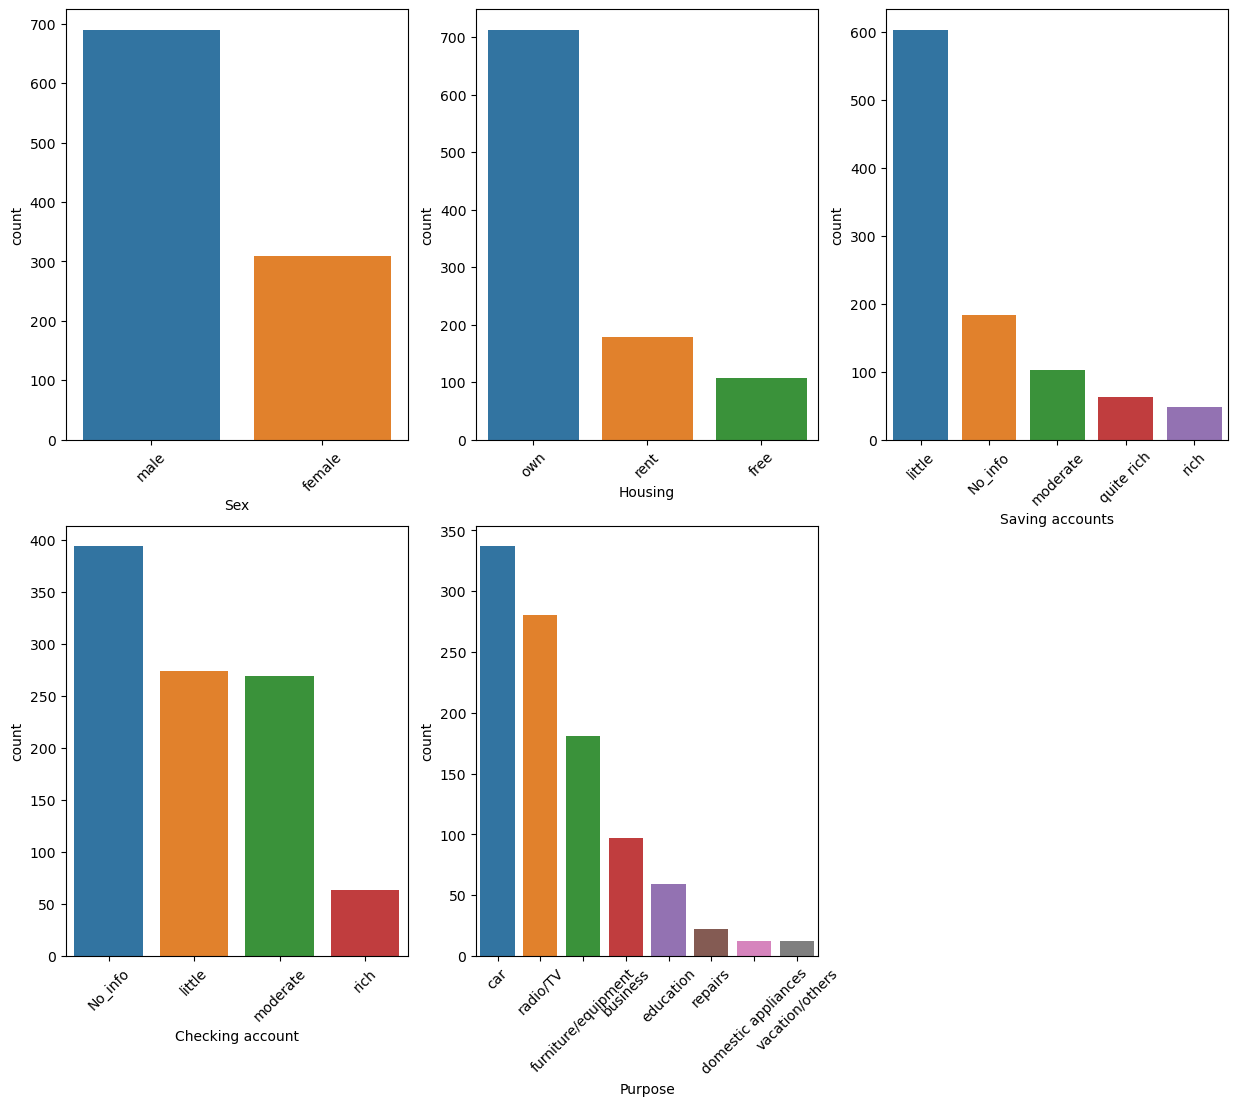

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=[15, 19])

for i, feature in enumerate(categorical_features):
    plt.subplot(3,3,i+1)
    sns.countplot(x=feature,data=df, order = df[feature].value_counts().index)
    plt.xticks(rotation = 45)

Итак, видно что фичи Checking Account + Saving account являются порядковыми, поэтому при переводе их в числа постараюсь сохранить этот поярдок. Все остальные - просто категории, для них можно использовать OneHot encoding/dummies для перевода в числа.
\
\
Если говорить о распределениях, то во всех признаках есть некоторые доминирующие категории, что должно помочь при выделении кластеров и их анализе.

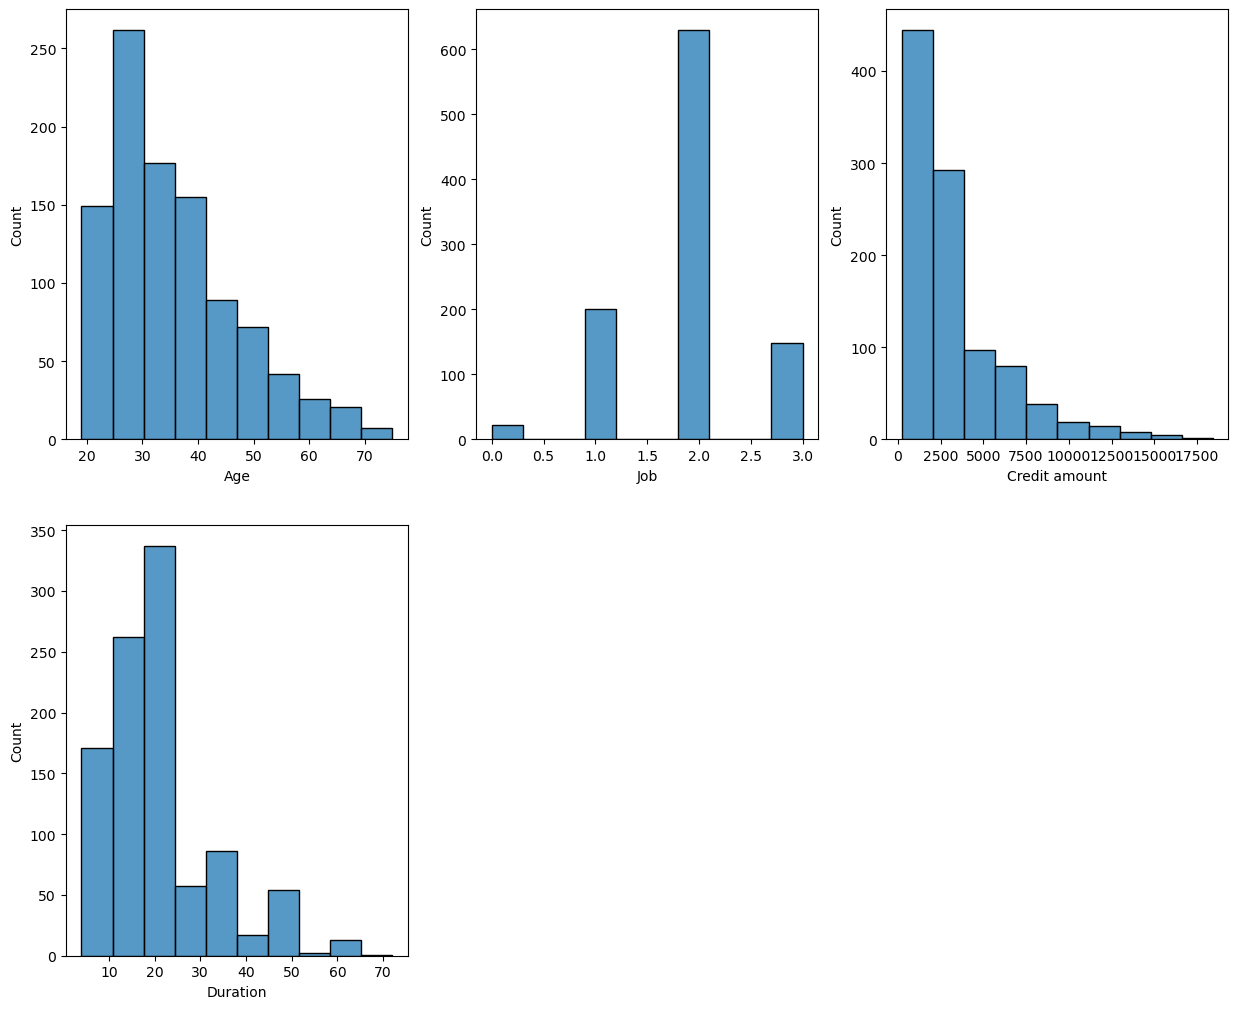

In [10]:
plt.figure(figsize=[15, 19])

for i, feature in enumerate(numeric_features):
    plt.subplot(3,3,i+1)
    sns.histplot(df[feature],bins = 10)

Распределения числовых признаков не совсем нормальные :). Есть доминирующие значения. Фича job - по факту категорильная порядковая.


Итак, переведем все категорильаные признаки в числа. При это оставим все столбцы (даже если они мультиколлинераны), так как это повлияет на модели.

In [11]:
df = pd.get_dummies(df, prefix = ['S', 'H','P'],\
                    columns = ['Sex', 'Housing', 'Purpose'], drop_first=False)

In [12]:
account_mapper = {'No_info':0, 'little':1, 'moderate':2, 'rich':3, 'quite rich':4}
df['Saving accounts'] = df['Saving accounts'].replace(account_mapper)
df['Checking account'] = df['Checking account'].replace(account_mapper)

In [13]:
df.describe()

,Age,Job,Saving accounts,Checking account,Credit amount,Duration,S_female,S_male,H_free,H_own,H_rent,P_business,P_car,P_domestic appliances,P_education,P_furniture/equipment,P_radio/TV,P_repairs,P_vacation/others
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,35.546000,1.904000,1.205000,1.001000,3271.258000,20.903000,0.310000,0.690000,0.108000,0.713000,0.179000,0.097000,0.337000,0.01200,0.059000,0.181000,0.280000,0.022000,0.01200
std,11.375469,0.653614,1.001988,0.957034,2822.736876,12.058814,0.462725,0.462725,0.310536,0.452588,0.383544,0.296106,0.472921,0.10894,0.235743,0.385211,0.449224,0.146757,0.10894
min,19.000000,0.000000,0.000000,0.000000,250.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,27.000000,2.000000,1.000000,0.000000,1365.500000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,33.000000,2.000000,1.000000,1.000000,2319.500000,18.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,42.000000,2.000000,1.000000,2.000000,3972.250000,24.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.00000
max,75.000000,3.000000,4.000000,3.000000,18424.000000,72.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Age                    1000 non-null   int64
 1   Job                    1000 non-null   int64
 2   Saving accounts        1000 non-null   int64
 3   Checking account       1000 non-null   int64
 4   Credit amount          1000 non-null   int64
 5   Duration               1000 non-null   int64
 6   S_female               1000 non-null   uint8
 7   S_male                 1000 non-null   uint8
 8   H_free                 1000 non-null   uint8
 9   H_own                  1000 non-null   uint8
 10  H_rent                 1000 non-null   uint8
 11  P_business             1000 non-null   uint8
 12  P_car                  1000 non-null   uint8
 13  P_domestic appliances  1000 non-null   uint8
 14  P_education            1000 non-null   uint8
 15  P_furniture/equipment  1000 non-null   

Последний шаг в предобработке данных - это нормализация данных при помощи Standard Scaler или MinMax Scaler. Я проведу небольшой эксперимент, чтобы проверить влияет ли сопособ нормализации на результаты кластеризации.

In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

scaler2 = MinMaxScaler()
df_scaled2 = scaler2.fit_transform(df)

# Часть 2. Моделирование.

## 2.1 KMeans

Начнем моделирование с KMeans. Поделим весь датасет на кластеры от 2 до 20 и оценим качество каждого кластера при помощи: 

<li> инерции или суммарного расстояния от центра кластера до точек. Оптимум - смена угла наклона в графике инерции

<li> силуэтного коэффициента - оптимум - ближайшее значение до +1

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

ssd= []
score = []

for k in range(2,21):
    model = KMeans(n_clusters = k, random_state=42)
    model.fit(df_scaled)
    scorek = silhouette_score(df_scaled, model.labels_,metric='euclidean')
    ssd.append(model.inertia_)
    score.append(scorek)

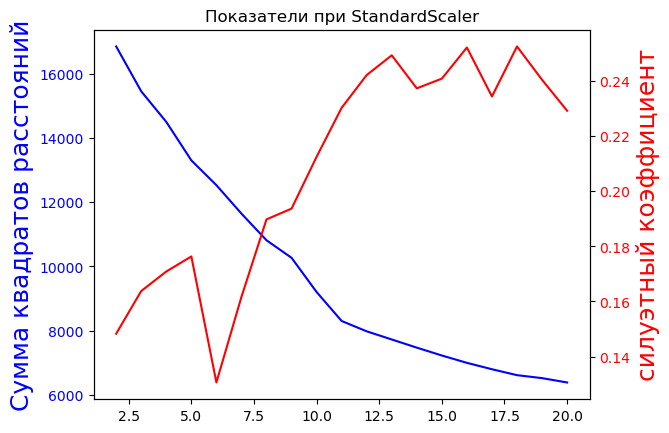

In [17]:
fig, ax = plt.subplots()
ax.plot(range(2,21), ssd, c = 'blue')
for label in ax.get_yticklabels():
    label.set_color('blue')
ax.set_ylabel("Сумма квадратов расстояний", fontsize=18, color="blue")
ax2 = ax.twinx()
ax2.plot(range(2,21), score, c = 'red')
for label in ax2.get_yticklabels():
    label.set_color('r')
ax2.set_ylabel("силуэтный коэффициент", fontsize=18, color="red")

ax.set_title('Показатели при StandardScaler')

plt.show()

In [18]:
ssd2= []
score2 = []

for k in range(2,21):
    model = KMeans(n_clusters = k, random_state=42)
    model.fit(df_scaled2)
    scorek = silhouette_score(df_scaled2, model.labels_,metric='euclidean')
    ssd2.append(model.inertia_)
    score2.append(scorek)

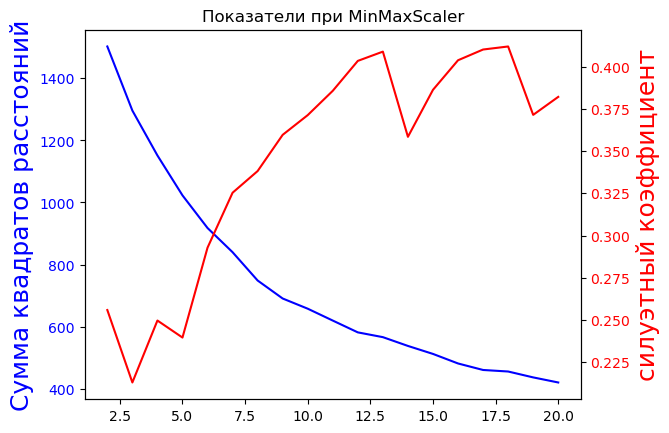

In [19]:
fig, ax = plt.subplots()
ax.plot(range(2,21), ssd2, c = 'blue')
for label in ax.get_yticklabels():
    label.set_color('blue')
ax.set_ylabel("Сумма квадратов расстояний", fontsize=18, color="blue")
ax2 = ax.twinx()
ax2.plot(range(2,21), score2, c = 'red')
for label in ax2.get_yticklabels():
    label.set_color('r')
ax2.set_ylabel("силуэтный коэффициент", fontsize=18, color="red")

ax.set_title('Показатели при MinMaxScaler')

plt.show()

## Предварительные выводы

Итак, механизм нормализации имеет небольшое значение значение, так как и при StandardScaler и при MinMaxScaler оптимальным является разбиение на 12-18 классов. 

При этом сильно выраженных переломных моментов на графиках инерции нет в обоих случаях. А графики силуэтного коэффициента ведут себя "неправильно" - растут при увеличении кол-ва кластеров. Данная тендеция может являться признаком сложных данных, которые четко не делятся на кластеры :)

Для 3-го этапа я буду использовать все-таки результаты по кластеризации данных после StandardScaler.

Воспользуемся библиотекой **yellowbrick**, чтобы визуализировать расчтеты силуэтного коэффициента и "локтевого" правила для данных после StandardScaler.

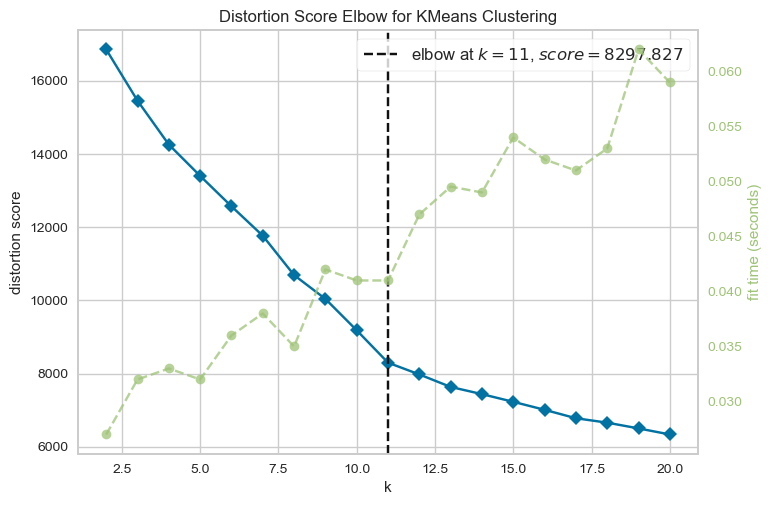

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [20]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,21))
visualizer.fit(df_scaled) # Fit the data to the visualizer
visualizer.show() 

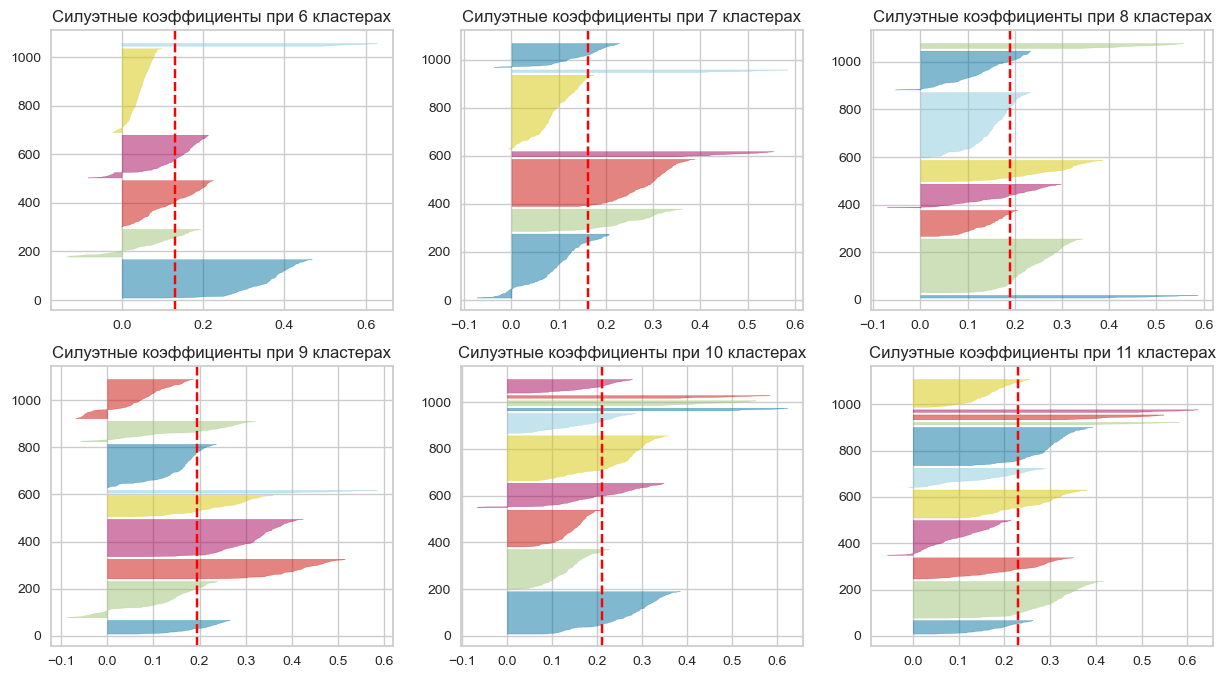

In [21]:
from yellowbrick.cluster import SilhouetteVisualizer
fig, ax = plt.subplots(2, 3, figsize=(15,8))
for i in range(6,12):
 
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[i//9][i%3])
    ax[i//9][i%3].title.set_text(f'Силуэтные коэффициенты при {i} кластерах')
    visualizer.fit(df_scaled)

Выводы радикально не поменялись. Библиотека **yellowbrick** выбрала как оптимум 11 кластеров по парвилу локтя. 

Если смотреть графики силуэтных коэффициентов при 6-11 кластерах, видно максимальное значение при разбивке в 11 кластеров (красная пунктирная линия), но при этом один из кластеров имеет суммарные коэффициент ниже среднего. С этой точки зрения - 10 кластеров более оптимально.

Если смотеть на распределение данных по кластерам (ширина "штриха" на последних графиках), то получается, что ни один из вариантов не дает сбалансированного по кластерам распределения. Из всех вариантов 10 кластеров визуально кажется более сбаланисрованным.

### Финальный вывод для KMeans:

Остановимся на 10 кластерах. Выведем метки для этого кол-ва и визуализируем на 2-мерной плоскости.


In [22]:
fin_model = KMeans(n_clusters = 10, random_state=42)
fin_model.fit(df_scaled)
df['KMeans'] = fin_model.labels_
df['KMeans'] = pd.Categorical(df.KMeans)
df['KMeans'].value_counts(normalize= True).sort_index()

0    0.182
1    0.171
2    0.158
3    0.105
4    0.193
5    0.086
6    0.012
7    0.022
8    0.012
9    0.059
Name: KMeans, dtype: float64

In [23]:
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE

# UMAP = uniform manifold approximation and projection
reducers_names =['PCA', 'UMAP', 'TSNE']
reducers = [PCA(n_components = 2), umap.UMAP(), TSNE(n_components=2, random_state=10)]

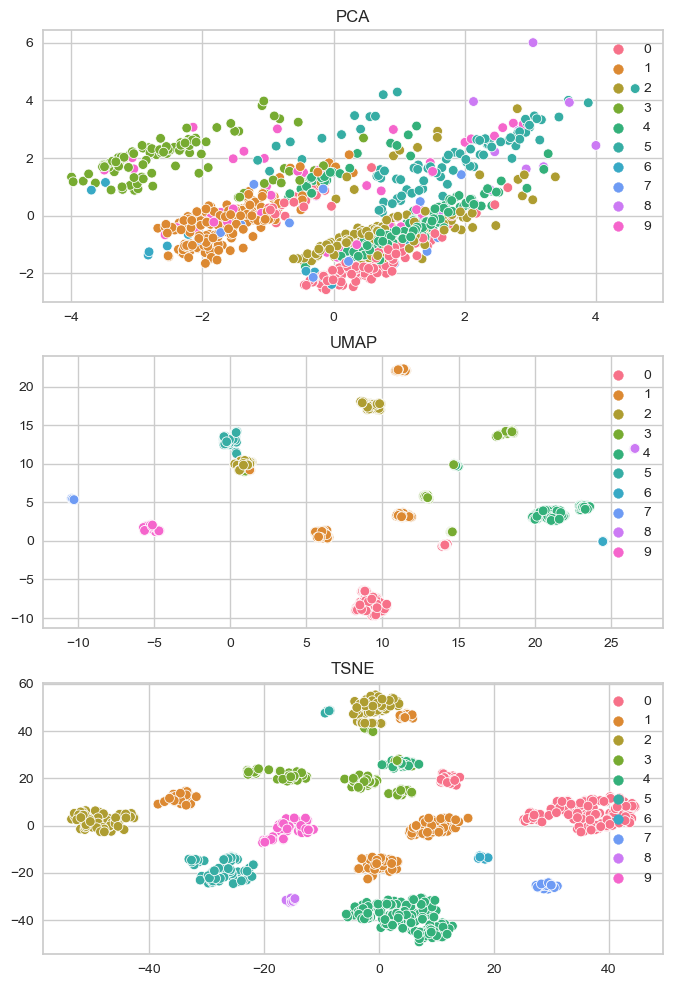

In [24]:
plt.figure(figsize=[8, 12])
plt.tight_layout()
counter = 1
for name, reducer in zip(reducers_names, reducers):
    df_reduced = reducer.fit_transform(df_scaled)
    plt.subplot(3,1, counter)
    sns.scatterplot(x = df_reduced[:,0],y = df_reduced[0:,1], hue = df['KMeans'], palette = 'husl')
    plt.title(name)
    plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1))
    counter += 1

Разные способы снижения размерности дали разные результаты :( совсем непохожие друг на друга. TSNE + UMAP выделили больше отдельно стоящих групп, которые были распознаны как отдельные кластеры KMeans, но судить о качестве в таком графике сложно. Буду делать это в части 3 при просмотре значений фичей для каждого кластера.


## 2.2 AgglomerativeClustering

Для оценки кластеров, выделенных с помощью этого алгоритма воспользуемся: 

<li> визуализацией в виде дендрограммы для 2-х кластеров
<li> посчитаем силуэтный коэффициент для кластеров от 2 до 20 и выберем оптимальный с максимальным значением, приближенным к единице.

In [25]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage


model = AgglomerativeClustering(n_clusters = 2)
cluster_labels = model.fit_predict(df_scaled)

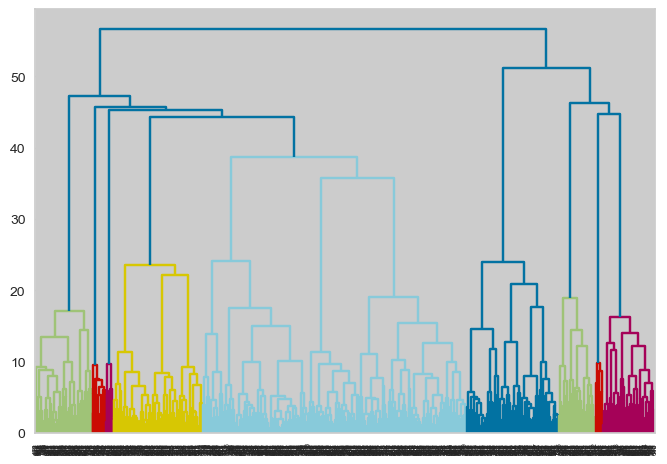

In [26]:
linkage_ = linkage(df_scaled, method='ward')
dendrogram = dendrogram(linkage_)

Дендрограмма не дает много информации, так как очень много данных.

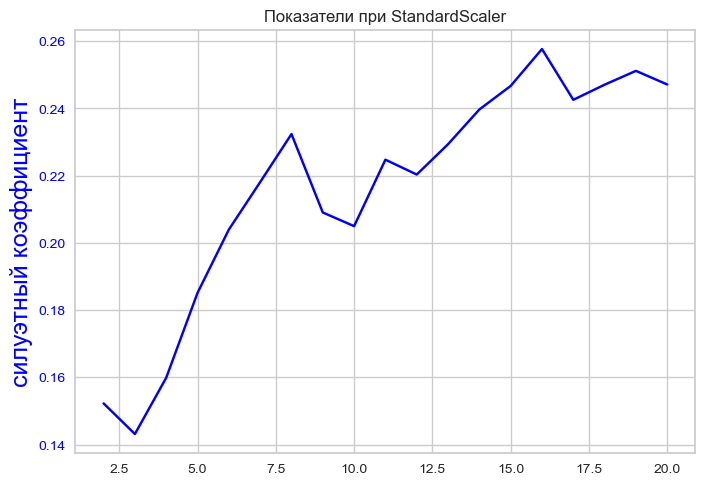

In [27]:
score = []
for k in range(2,21):
    model = AgglomerativeClustering(n_clusters = k)
    model.fit(df_scaled)
    scorek = silhouette_score(df_scaled, model.labels_,metric='euclidean')
    score.append(scorek)

fig, ax = plt.subplots()
ax.plot(range(2,21), score, c = 'blue')
for label in ax.get_yticklabels():
    label.set_color('blue')
ax.set_ylabel("силуэтный коэффициент", fontsize=18, color="blue")
ax.set_title('Показатели при StandardScaler')
plt.show()

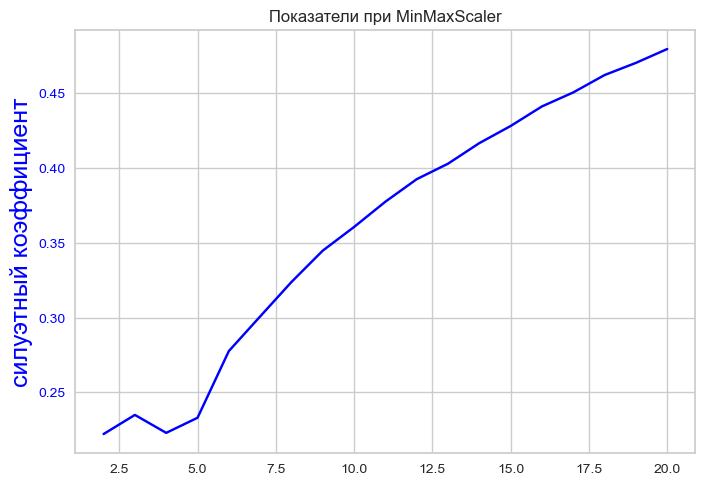

In [28]:
score = []
for k in range(2,21):
    model = AgglomerativeClustering(n_clusters = k)
    model.fit(df_scaled2)
    scorek = silhouette_score(df_scaled2, model.labels_,metric='euclidean')
    score.append(scorek)

fig, ax = plt.subplots()
ax.plot(range(2,21), score, c = 'blue')
for label in ax.get_yticklabels():
    label.set_color('blue')
ax.set_ylabel("силуэтный коэффициент", fontsize=18, color="blue")
ax.set_title('Показатели при MinMaxScaler')
plt.show()

## Выводы для AgglomerativeClustering

Силуэтный коэффициент ведет себя также как и при использовании KMeans - растет при увеличении кол-ва кластеров.

Для расчета меток возьмем 10 кластеров при Standard Scaler, так как пиковое значние силуэтного коэффициента для 16 кластеров, но это очень много для анализа. Возьмем 10 как и для KMeans

In [29]:
fin_model = AgglomerativeClustering(n_clusters = 10)
fin_model.fit(df_scaled)
df['AggClust'] = fin_model.labels_
df['AggClust'] = pd.Categorical(df.AggClust)
df['AggClust'].value_counts(normalize= True).sort_index()

0    0.255
1    0.171
2    0.149
3    0.059
4    0.144
5    0.022
6    0.012
7    0.012
8    0.092
9    0.084
Name: AggClust, dtype: float64

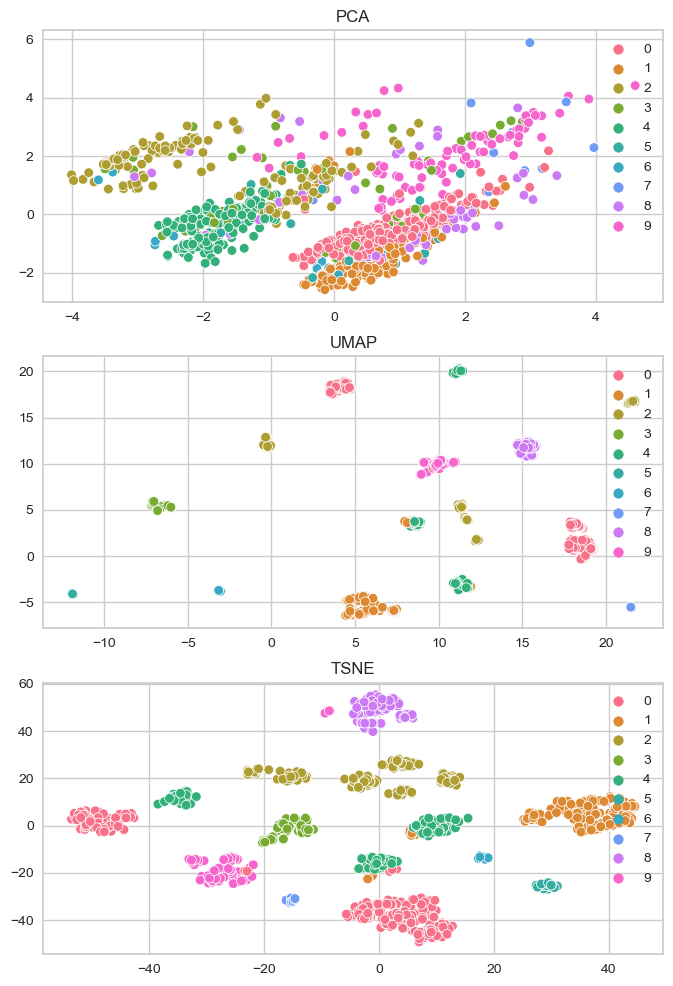

In [30]:
plt.figure(figsize=[8, 12])
plt.tight_layout()
counter = 1
for name, reducer in zip(reducers_names, reducers):
    df_reduced = reducer.fit_transform(df_scaled)
    plt.subplot(3,1, counter)
    sns.scatterplot(x = df_reduced[:,0],y = df_reduced[0:,1], hue = df['AggClust'], palette = 'husl')
    plt.title(name)
    plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1))
    counter += 1

Похожий результат на KMEANS особенно видно на UMAP + TSNA: все отдельно лежащие "облачка" данных выделены в отдельный класс (за редким исключением)


## 2.3 DBSCAN

Буду смотреть качество кластеров сравнивания величину силуэтного коэффициента и соответсвующего кол-ва кластеров при использовании гперпараметров DBSCAN:

<li> радиуса окрестности eps
<li> кол-во точек в рамках радиуса окрестности min_samples

In [31]:
from sklearn.cluster import DBSCAN

silhoutee = []
clusters = []
eps_range = np.arange(0.5, 6, 0.1)

for i in eps_range:
    dbscan = DBSCAN(eps = i).fit(df_scaled)
    labels = dbscan.labels_
    uniq_labels = np.unique(labels)
    n_clusters = len(uniq_labels[uniq_labels != -1])
    if n_clusters > 1:
        score = silhouette_score(df_scaled, labels)
    else:
        score = 0
    silhoutee.append(score)
    clusters.append(n_clusters)

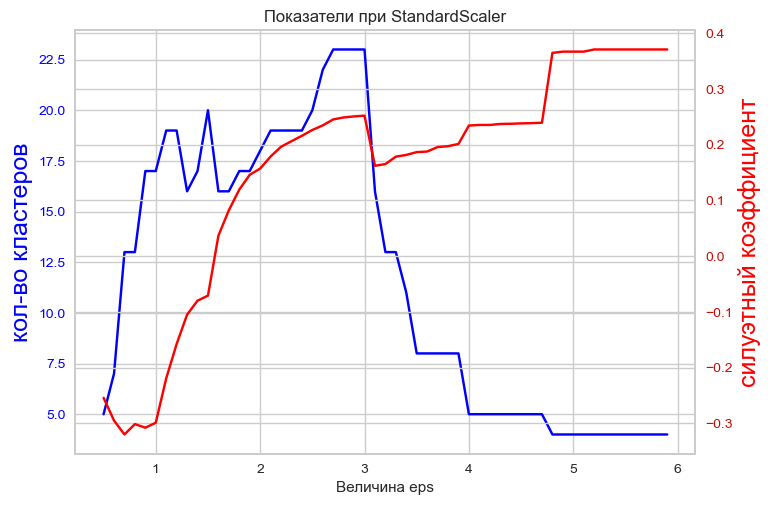

In [32]:
fig, ax = plt.subplots()
ax.plot(eps_range, clusters, c = 'blue')
for label in ax.get_yticklabels():
    label.set_color('blue')
ax.set_ylabel("кол-во кластеров", fontsize=18, color="blue")
ax2 = ax.twinx()
ax2.plot(eps_range, silhoutee, c = 'red')
for label in ax2.get_yticklabels():
    label.set_color('r')
ax2.set_ylabel("силуэтный коэффициент", fontsize=18, color="red")
ax.set_title('Показатели при StandardScaler')
ax.set_xlabel('Величина eps')

plt.show()

In [33]:
silhoutee = []
clusters = []
eps_range = np.arange(0.5, 6, 0.1)

for i in eps_range:
    dbscan = DBSCAN(eps = i).fit(df_scaled2)
    labels = dbscan.labels_
    uniq_labels = np.unique(labels)
    n_clusters = len(uniq_labels[uniq_labels != -1])
    if n_clusters > 1:
        score = silhouette_score(df_scaled2, labels)
    else:
        score = 0
    silhoutee.append(score)
    clusters.append(n_clusters)

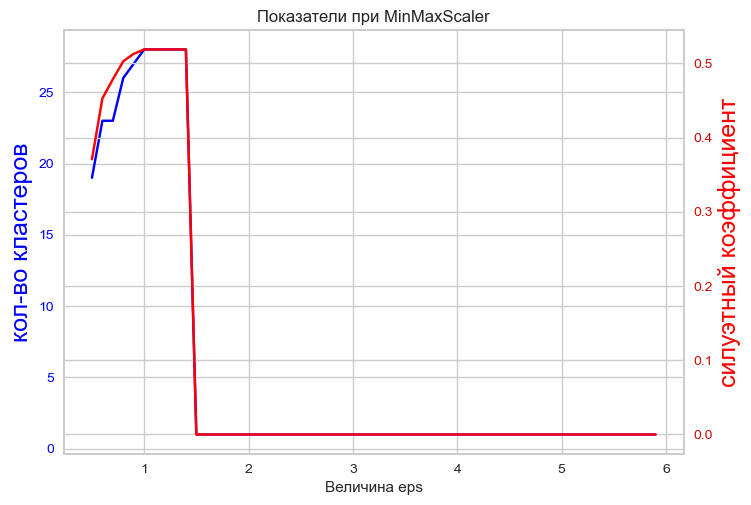

In [34]:
fig, ax = plt.subplots()
ax.plot(eps_range, clusters, c = 'blue')
for label in ax.get_yticklabels():
    label.set_color('blue')
ax.set_ylabel("кол-во кластеров", fontsize=18, color="blue")
ax2 = ax.twinx()
ax2.plot(eps_range, silhoutee, c = 'red')
for label in ax2.get_yticklabels():
    label.set_color('r')
ax2.set_ylabel("силуэтный коэффициент", fontsize=18, color="red")
ax.set_title('Показатели при MinMaxScaler')
ax.set_xlabel('Величина eps')

plt.show()

### Промежуточные выводы:

Вариант с MinMaxScaler отбрасываем совсем, он не дал корректных результатов.

При StandardScaler радиус (eps) нужно брать больше **4**, так как начиная с этой величины кол-во кластеров становится стабильным и отличным от 1, а также силуэтный коэффициент имеет максимальное значение. 

Интересно, что величина силуэтного коэффициента выше чем в предыдущих моделях. Хочется думать, что DBSCAN смог лучше кластеризовать данные.

Следующим шагом, посмотрим как будет влиять кол-во точек в радиусе **(min_samples)** на силуэтный коэффициент.

In [35]:
silhoutee = []
clusters = []
samples_range = np.arange(2, 15, 1)

for i in samples_range:
    dbscan = DBSCAN(eps = 4.5, min_samples=i).fit(df_scaled)
    labels = dbscan.labels_
    uniq_labels = np.unique(labels)
    n_clusters = len(uniq_labels[uniq_labels != -1])
    if n_clusters > 1:
        score = silhouette_score(df_scaled, labels)
    else:
        score = 0
    silhoutee.append(score)
    clusters.append(n_clusters)

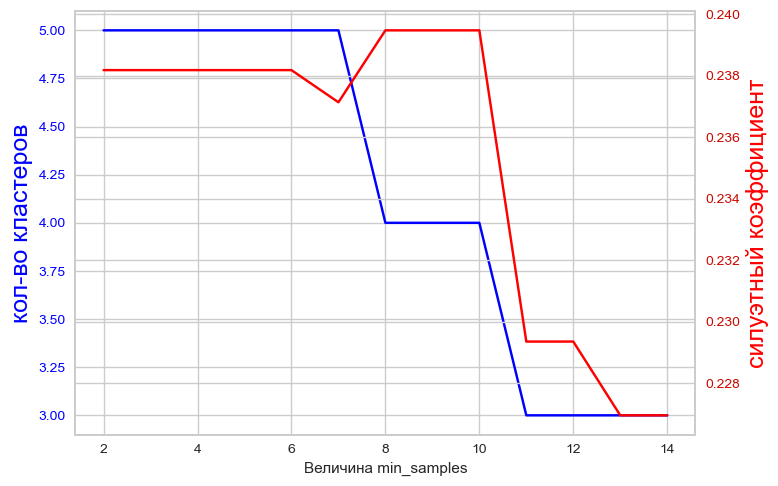

In [36]:
fig, ax = plt.subplots()
ax.plot(samples_range, clusters, c = 'blue')
for label in ax.get_yticklabels():
    label.set_color('blue')
ax.set_ylabel("кол-во кластеров", fontsize=18, color="blue")
ax2 = ax.twinx()
ax2.plot(samples_range, silhoutee, c = 'red')
for label in ax2.get_yticklabels():
    label.set_color('r')
ax2.set_ylabel("силуэтный коэффициент", fontsize=18, color="red")
ax.set_xlabel('Величина min_samples')

plt.show()


Максимальная величина силуэтного коэффициента при стабильном кол-ве классов достигается при 9-10 точках в окрестности.

## Финальные выводы по DBSCAN:

Для дальнейшего анализа возьмем eps = 4.5 и min_samples = 9

In [37]:
dbscan = DBSCAN(eps = 4.5, min_samples=9).fit(df_scaled)

df['DBSCAN'] = dbscan.labels_
df['DBSCAN'] = pd.Categorical(df.DBSCAN)
df['DBSCAN'].value_counts(normalize= True).sort_index()

-1    0.014
0     0.895
1     0.059
2     0.020
3     0.012
Name: DBSCAN, dtype: float64

Как-то не очень хорошо получилось, при довольно высоком радиусе и большом кол-ве точек в окрестности получился один основной класс. Не всегда коэффициент дает корректный результат. Уменьшим кол-во точек до следующего максимума коэффициент - до 3.3, а радиус до 7.

При этом 8% всех данных у нас попадет в outliers.

Если будем увеличивать оба гиперпараметра вместе или по отдельности, будет расти величина доминирующего кластера. Остановимся на этих значениях

In [38]:
dbscan = DBSCAN(eps = 3.3, min_samples=7).fit(df_scaled)

df['DBSCAN'] = dbscan.labels_
df['DBSCAN'] = pd.Categorical(df.DBSCAN)
df['DBSCAN'].value_counts(normalize= True).sort_index()

-1    0.087
0     0.443
1     0.034
2     0.010
3     0.061
4     0.122
5     0.099
6     0.076
7     0.007
8     0.013
9     0.048
Name: DBSCAN, dtype: float64

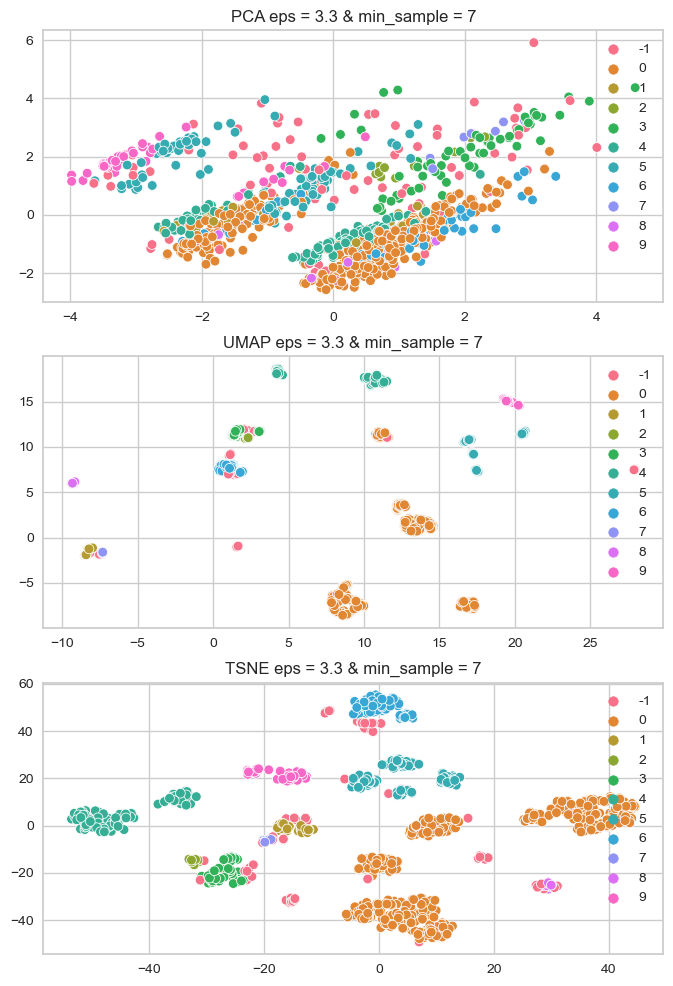

In [39]:
plt.figure(figsize=[8, 12])
plt.tight_layout()
counter = 1
for name, reducer in zip(reducers_names, reducers):
    df_reduced = reducer.fit_transform(df_scaled)
    plt.subplot(3,1, counter)
    sns.scatterplot(x = df_reduced[:,0],y = df_reduced[0:,1], hue = df['DBSCAN'], palette = 'husl')
    plt.title(f'{name} eps = 3.3 & min_sample = 7')
    plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1))
    counter += 1

# Часть 3. Интерпретация

Для интерпретации результов по каждой модели (KMeans, Agglemerating Clustering, DBSCAN) сгруппируем датасет по выделенным кластерам и посмотрим на медианные значения признаков.

Я выбрала мединанные, так как хотела посмотреть на самые часто встречаемые величины в признаке в рамках выделенного кластера.

Затем я решила построить barplot для каждого признака вместо рекомендуемых в задании boxplot, так как они лучше отражают переведенные категориальные признаки.


## 3.1 KMeans кластеры

In [40]:
df.groupby('KMeans').median()

,Age,Job,Saving accounts,Checking account,Credit amount,Duration,S_female,S_male,H_free,H_own,H_rent,P_business,P_car,P_domestic appliances,P_education,P_furniture/equipment,P_radio/TV,P_repairs,P_vacation/others
KMeans,,,,,,,,,,,,,,,,,,,
0,33.0,2.0,1.0,1.0,1935.0,18.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,30.0,2.0,1.0,1.0,1842.0,18.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,33.5,2.0,1.0,1.0,2763.0,24.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,25.0,2.0,1.0,1.0,2301.0,18.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,36.0,2.0,1.0,1.0,2476.0,18.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,42.0,2.0,1.0,1.0,3800.5,24.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,28.0,2.0,1.0,1.0,1249.0,13.5,0.5,0.5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,33.5,2.0,1.0,1.0,1749.0,16.5,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,39.5,3.0,1.0,2.0,6948.0,24.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [50]:
columns_to_plot = ['Age', 'Job', 'Saving accounts', 'Checking account', 'Credit amount',
       'Duration', 'S_female', 'S_male', 'H_free', 'H_own', 'H_rent',
       'P_business', 'P_car', 'P_domestic appliances', 'P_education',
       'P_furniture/equipment', 'P_radio/TV', 'P_repairs', 'P_vacation/others']

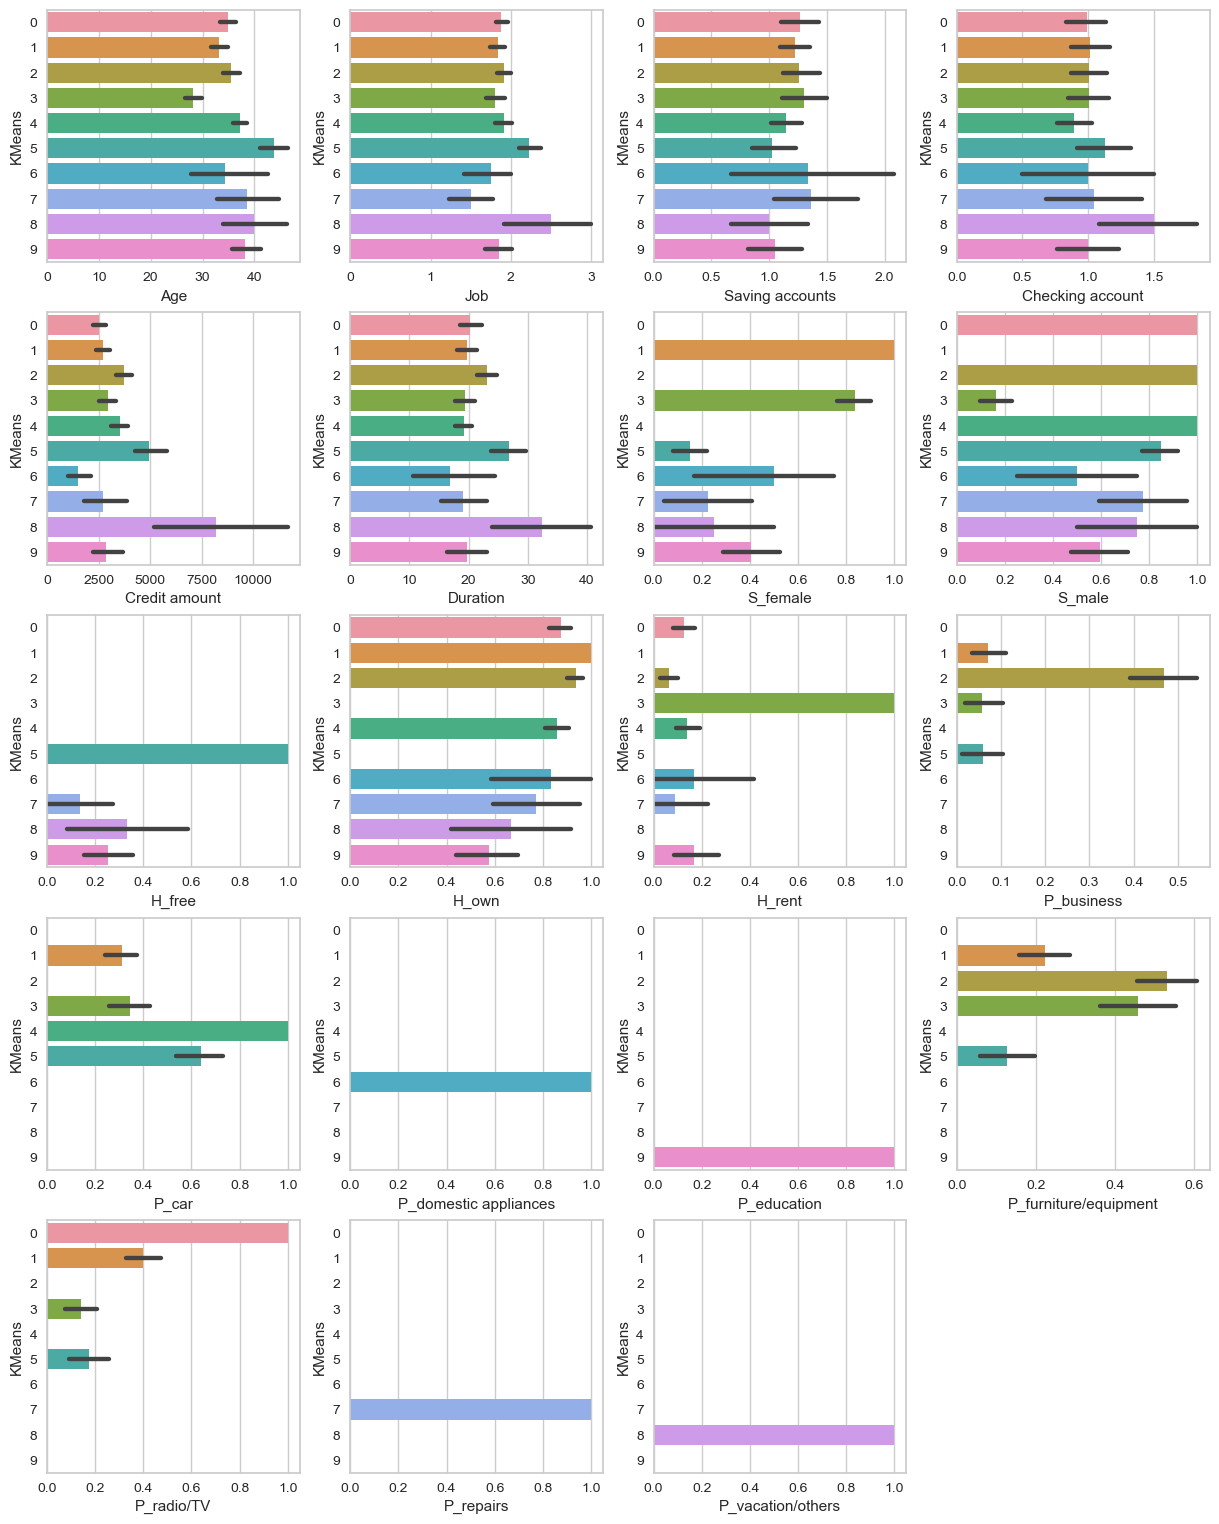

In [51]:
plt.figure(figsize=[15, 19])
#plt.tight_layout()
for i, feature in enumerate(columns_to_plot):
    plt.subplot(5,4,i+1)
    sns.barplot(y='KMeans', x = feature, data=df)
    #plt.xticks(rotation = 45)

# Выводы по кластерам от KMeans:

**Кластер 0 = "Мужчины-любители ТВ-техники"**
> Особых оличительных черт у кластера нет, кроме того, что абсолютное большинство представителей кластера берет кредит на покупку ТВ и на 100% состоит из мужчин. 80% всех представителей владеют недвижимостью. Работают на работе с тегом 2 (skilled), но при этом кредиты берут на небольшие суммы. Могут быть интересны с точки зрения повышения суммы кредитования

**Кластер 1 = "Женщины-любители техники и машин"**
> На 100% состоит из женщин, которые берут кредит на покупку машин (30% из всех), мебели (20%) и ТВ-техники (40%). Почти 100% из них являются владельцами недвижимости. По остальным признакам очень похожи на кластер 0, также бурут небольшие кредиты <

**Кластер 2 = "Индивидуальные предприниматели"**
> Этот кластер состоит из мужчин, бурщих кредиты в 50% на финансирование бизнеса, в 50% на покупку оборудования. У них есть недвижимость. Остальные признаки походи на 2 предыдущих кластера.

**Кластер 3 = "Арендаторы из молодежи"**
> Самый молодой кластер, все арендуют недвижимость, берут кредиты на покупку мебели и машин. Сумма кредитов небольшая.<

**Кластер 4 = "Мужчины-автолюбители"**
> Берут кредиты исключительно на покупку машин, в большинстве 80% являются домовладельцами. С точки зрения возраста старше чем в кластерах 0-3

**Кластер 5 = "Возрастные бездомные"**
> Самая возрастная группа, не владеют и не арендую недвижимость. Берут кредиты на машину 60%, либо на оборудование и мебелью

**Кластер 6 = "Против кредитов"**
> Берут кредиты меньше всех других групп и на самые короткие сроки. 50/50 мужчины/женщины. В основном владеют недвижимостью.

**Кластер 7 = "Любители ремонта"**
> Берут кредит на ремонт. На 80% мужчины, в основном владеют недвижимостью.

**Кластер 8 = "Любители отдыха"**
> Берут кредит на отдых. Не самые молодые, при этом в этой группе самое большое кол-во высококвалфицированных специалистов (тег работы = 3). Самые большие счета (категории rich).Берут самые большие кредиты на самый долгий срок.

**Кластер 9 = "Вечные студенты"**
> Берут кредит на образование. Остальные показатели не особо выделяются


## 3.2  Agglemerating Clustering кластеры

In [43]:
df.groupby('AggClust').median()

,Age,Job,Saving accounts,Checking account,Credit amount,Duration,S_female,S_male,H_free,H_own,H_rent,P_business,P_car,P_domestic appliances,P_education,P_furniture/equipment,P_radio/TV,P_repairs,P_vacation/others
AggClust,,,,,,,,,,,,,,,,,,,
0,35.0,2.0,1.0,1.0,2538.0,18.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,33.0,2.0,1.0,1.0,2051.0,18.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,26.0,2.0,1.0,1.0,2235.0,16.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,36.0,2.0,1.0,1.0,1597.0,12.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,29.5,2.0,1.0,1.0,1692.5,15.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,33.5,2.0,1.0,1.0,1749.0,16.5,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,28.0,2.0,1.0,1.0,1249.0,13.5,0.5,0.5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,39.5,3.0,1.0,2.0,6948.0,24.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,32.5,2.0,1.0,1.0,3041.0,24.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


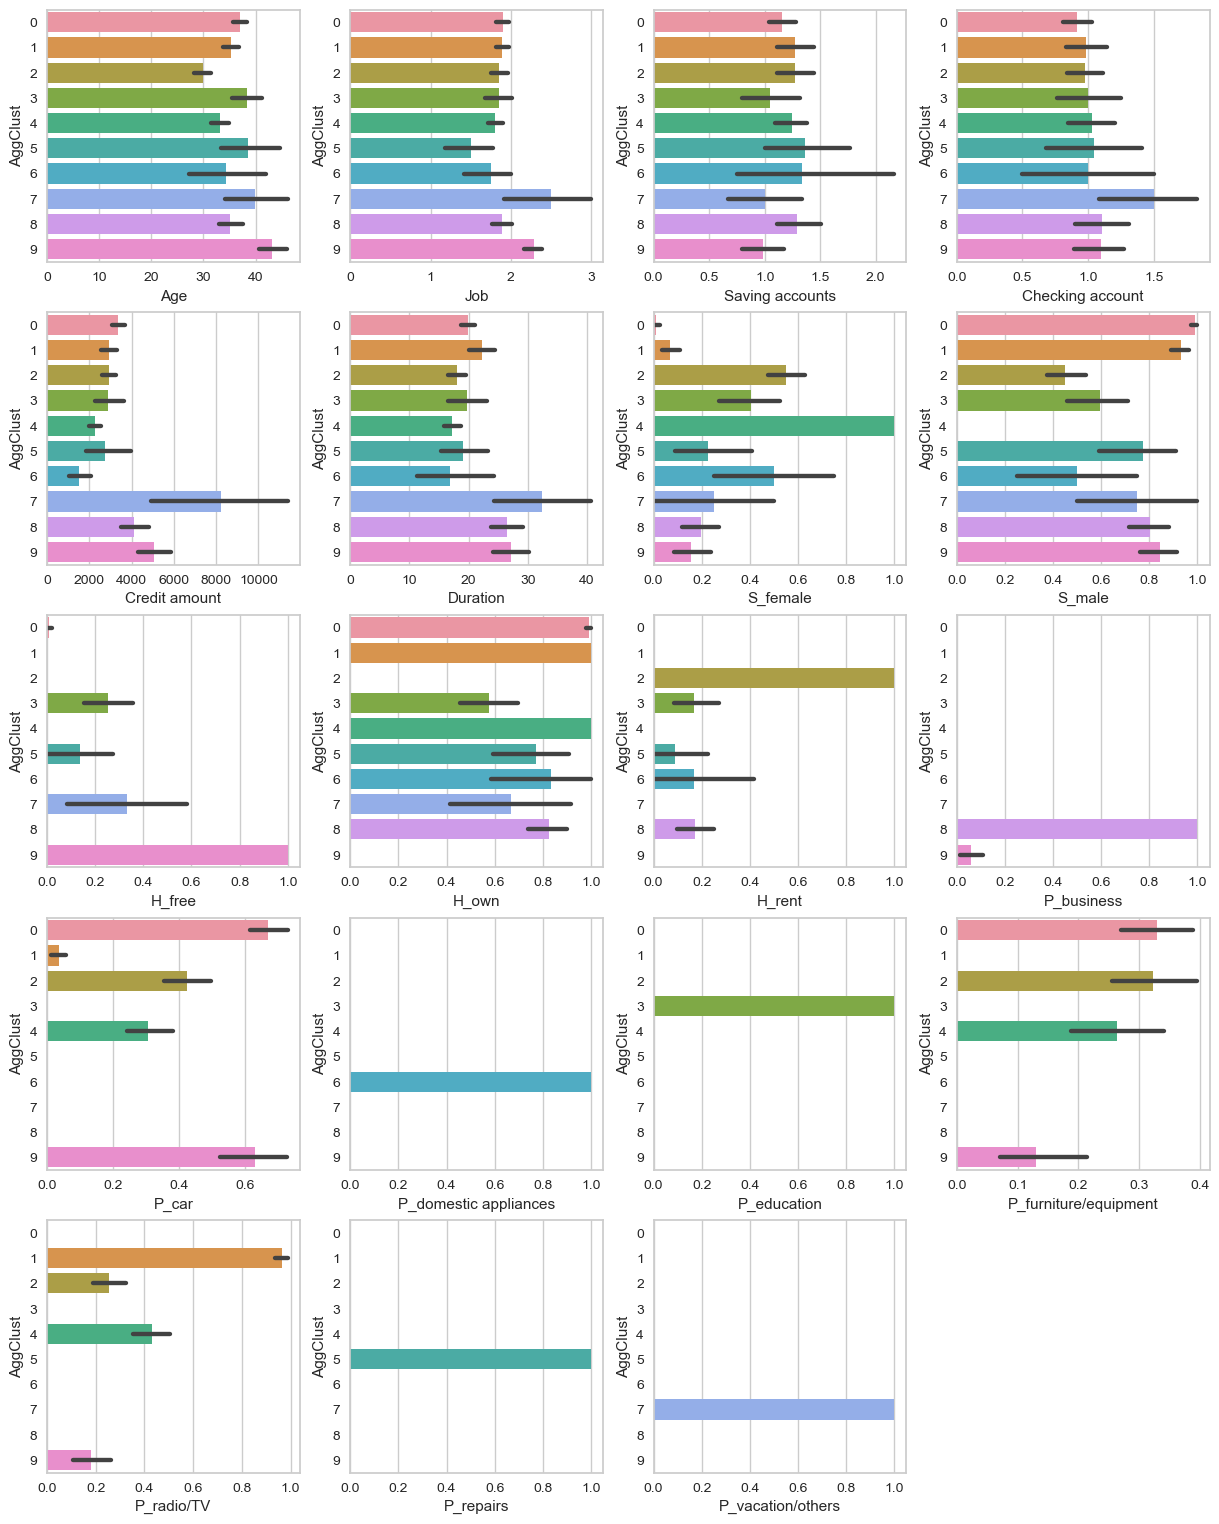

In [52]:
plt.figure(figsize=[15, 19])
#plt.tight_layout()
for i, feature in enumerate(columns_to_plot):
    plt.subplot(5,4,i+1)
    sns.barplot(y='AggClust', x = feature, data=df)
    #plt.xticks(rotation = 45)

# Выводы по кластерам от Agglemerating Clustering:

Характеристики кластеров, выделенные агломеративным алгоритмом очень похожи на те, что выделил KMeans.
Я не буду останавливаться на них детально.


## 3.3  DBSCAN кластеры

In [45]:
df.groupby('DBSCAN').median()

,Age,Job,Saving accounts,Checking account,Credit amount,Duration,S_female,S_male,H_free,H_own,H_rent,P_business,P_car,P_domestic appliances,P_education,P_furniture/equipment,P_radio/TV,P_repairs,P_vacation/others
DBSCAN,,,,,,,,,,,,,,,,,,,
-1,35.0,2.0,1.0,2.0,2631.0,21.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,34.0,2.0,1.0,1.0,2100.0,18.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,36.5,2.0,1.0,0.5,1516.5,12.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,40.5,2.0,1.0,1.0,3246.0,24.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,42.0,2.0,1.0,1.0,4605.0,24.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,31.5,2.0,1.0,1.0,2618.0,18.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,28.0,2.0,1.0,1.0,2235.0,18.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,32.5,2.0,1.0,1.0,2693.0,24.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,42.0,2.0,1.0,0.0,6224.0,48.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


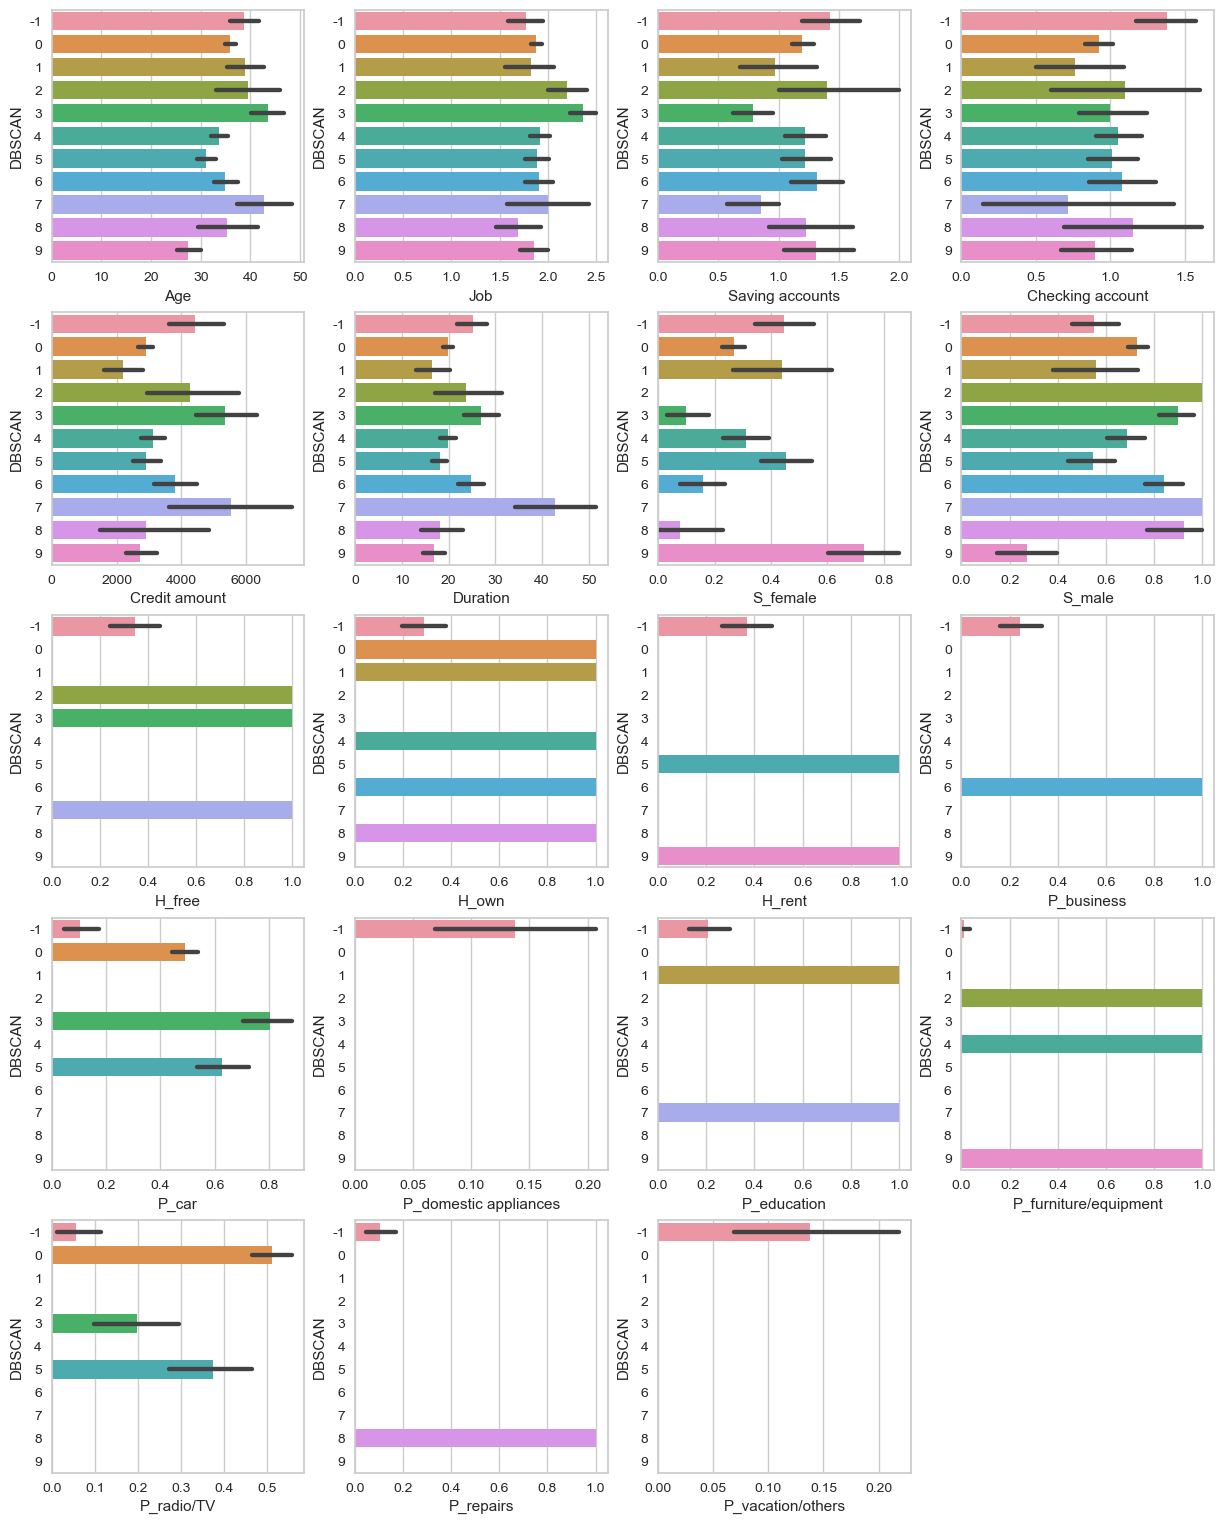

In [53]:
plt.figure(figsize=[15, 19])
#plt.tight_layout()
for i, feature in enumerate(columns_to_plot):
    plt.subplot(5,4,i+1)
    sns.barplot(y='DBSCAN', x = feature, data=df)
    #plt.xticks(rotation = 45)

# Выводы по кластерам от DBSCAN:

А вот DBSCAN разбил иначе от предыдущих алгоритмов.

В качестве выбросов он отобрал самых богатых клиентов, которые берут кредиты на отдых. Это не совсем понятно, или это редкий признак, или все остальные фичи не вписываются в прочие кластеры.

<li>Группа 0 = это любители техники, но здесь не 100%, а только 80% мужчины :). 
<li>Группа 1 = вечные студенты со своей недвижимостью. 
<li>Группа 2 = богатые бездомные. Эта группа немного моложе, чем в предыдущих алгоритмах.
 <li>Группа 3 = самые возрастные бездомные высококвалифицированные специалисты. Такой группы не было в предыдущих алгоритмах. Берут большие кредит, но не надолго. В основном на покупку машины.
    <li>Группа 4 = Женщины-любители техники и машин
    <li>Группа 5 = Арендаторы против кредиты. Берут небольшие кредиты в основном на машину и ТВ оборудование. Такой группы не было в предыдущих моделях.
    <li>Группа 6 = Индивидуальные предприниматели
    <li>Группа 7 = вечные студенты арендаторыю Берут самые большие кредиты и на самый долгий срок.
    <li>Группа 8 = Любители ремонта
    <li>Группа 9 = Арендаторы, берущие кредит на мебель.
        
        
 
# Финальный вывод:
        
Все 3 алгоритма разделили на похожие группы, при этом КMeans и Agglemerate Clustering оказались очень похожи. DBSCAN нашел другие особенности в данных.